# NCF Recommender with Explict Feedback

In this notebook we demostrate how to build a neural network recommendation system, Neural Collaborative Filtering(NCF) with explict feedback. We use Recommender API in Analytics Zoo to build a model, and use optimizer of BigDL to train the model. 

The system ([Recommendation systems: Principles, methods and evaluation](http://www.sciencedirect.com/science/article/pii/S1110866515000341)) normally prompts the user through the system interface to provide ratings for items in order to construct and improve the model. The accuracy of recommendation depends on the quantity of ratings provided by the user.  

NCF([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)) leverages a multi-layer perceptrons to learn the user–item interaction function, at the mean time, NCF can express and generalize matrix factorization under its framework. includeMF(Boolean) is provided for users to build a NCF with or without matrix factorization. 

Data: 
* The dataset we used is movielens-1M ([link](https://grouplens.org/datasets/movielens/1m/)), which contains 1 million ratings from 6000 users on 4000 movies.  There're 5 levels of rating. We will try classify each (user,movie) pair into 5 classes and evaluate the effect of algortithms using Mean Absolute Error.  
  
References: 
* A Keras implementation of Movie Recommendation([notebook](https://github.com/ririw/ririw.github.io/blob/master/assets/Recommending%20movies.ipynb)) from the [blog](http://blog.richardweiss.org/2016/09/25/movie-embeddings.html).
* Nerual Collaborative filtering ([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf))

## Intialization

import necessary libraries

In [23]:
from zoo.pipeline.api.keras.layers import *
from zoo.models.recommendation import UserItemFeature
from zoo.models.recommendation import NeuralCF
from zoo.common.nncontext import init_nncontext
import matplotlib
from sklearn import metrics
from operator import itemgetter
from bigdl.dataset import movielens
from bigdl.util.common import *

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Initilaize NN context, it will get a SparkContext with optimized configuration for BigDL performance.

In [24]:
sc = init_nncontext("NCF Example")

## Data Preparation

Download and read movielens 1M data

In [25]:
movielens_data = movielens.get_id_ratings("/tmp/movielens/")	

Understand the data. Each record is in format of (userid, movieid, rating_score). UserIDs range between 1 and 6040. MovieIDs range between 1 and 3952. Ratings are made on a 5-star scale (whole-star ratings only). Counts of users and movies are recorded for later use.

In [26]:
min_user_id = np.min(movielens_data[:,0])
max_user_id = np.max(movielens_data[:,0])
min_movie_id = np.min(movielens_data[:,1])
max_movie_id = np.max(movielens_data[:,1])
rating_labels= np.unique(movielens_data[:,2])

print(movielens_data.shape)
print(min_user_id, max_user_id, min_movie_id, max_movie_id, rating_labels)

(1000209, 3)
(1, 6040, 1, 3952, array([1, 2, 3, 4, 5]))


Transform original data into RDD of sample. 
We use optimizer of BigDL directly to train the model, it requires data to be provided in format of RDD([Sample](https://bigdl-project.github.io/master/#APIGuide/Data/#sample)). A `Sample` is a BigDL data structure which can be constructed using 2 numpy arrays, `feature` and `label` respectively. The API interface is `Sample.from_ndarray(feature, label)`

In [27]:
def build_sample(user_id, item_id, rating):
    sample = Sample.from_ndarray(np.array([user_id, item_id]), np.array([rating]))
    sample = Sample.from_ndarray(np.array([user_id, item_id]), np.array([rating]))
    return UserItemFeature(user_id, item_id, sample)
pairFeatureRdds = sc.parallelize(movielens_data).map(lambda x: build_sample(x[0], x[1], x[2]))
pairFeatureRdds.take(3)

Randomly split the data into train (80%) and validation (20%)

In [28]:
trainPairFeatureRdds, valPairFeatureRdds = pairFeatureRdds.randomSplit([0.8, 0.2], seed= 1)
valPairFeatureRdds.cache()
train_rdd= trainPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)
val_rdd= valPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)

In [29]:
print(train_rdd.count())
train_rdd.take(3)

799923


[Sample: features: [JTensor: storage: [  1. 661.], shape: [2], float], labels: [JTensor: storage: [3.], shape: [1], float],
 Sample: features: [JTensor: storage: [  1. 914.], shape: [2], float], labels: [JTensor: storage: [3.], shape: [1], float],
 Sample: features: [JTensor: storage: [1.000e+00 3.408e+03], shape: [2], float], labels: [JTensor: storage: [4.], shape: [1], float]]

## Build Model

In Analytics Zoo, it is simple to build NCF model by calling NeuralCF API. You need specify the user count, item count and class number according to your data, then add hidden layers as needed, you can also choose to include matrix factorization in the network. The model could be fed into an Optimizer of BigDL or NNClassifier of analytics-zoo. Please refer to the document for more details. In this example, we demostrate how to use optimizer of BigDL. 

In [41]:
ncf = NeuralCF(user_count=max_user_id, 
               item_count=max_movie_id, 
               class_num=5, 
               hidden_layers=[20, 10], 
               include_mf = False)

creating: createZooKerasInput
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasEmbedding
creating: createZooKerasEmbedding
creating: createZooKerasFlatten
creating: createZooKerasFlatten
creating: createZooKerasMerge
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createZooNeuralCF


## Compile model

Compile model given specific optimizers, loss, as well as metrics for evaluation. Optimizer tries to minimize the loss of the neural net with respect to its weights/biases, over the training set. To create an Optimizer in BigDL, you want to at least specify arguments: model(a neural network model), criterion(the loss function), traing_rdd(training dataset) and batch size. Please refer to ([ProgrammingGuide](https://bigdl-project.github.io/master/#ProgrammingGuide/optimization/))and ([Optimizer](https://bigdl-project.github.io/master/#APIGuide/Optimizers/Optimizer/)) for more details to create efficient optimizers.

In [42]:
ncf.compile(optimizer= "adam",
            loss= SparseCategoricalCrossEntropy(zero_based_label = False),
            metrics=['mae'])

creating: createZooKerasSparseCategoricalCrossEntropy
creating: createAdam
creating: createZooKerasMAE


## Collect logs

You can leverage tensorboard to see the summaries.

In [43]:
tmp_log_dir = create_tmp_path()
ncf.set_tensorboard(tmp_log_dir, "training_ncf")

## Train the model

In [44]:
ncf.fit(train_rdd, 
        nb_epoch= 10, 
        batch_size= 2800, 
        validation_data=val_rdd)

## Prediction

Zoo models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted label. 

In [45]:
results = ncf.predict(val_rdd)
results.take(5)

results_class = ncf.predict_class(val_rdd)
results_class.take(5)

[5, 4, 4, 4, 4]

In Analytics Zoo, Recommender has provied 3 unique APIs to predict user-item pairs and make recommendations for users or items given candidates.
Predict for user item pairs

In [46]:
userItemPairPrediction = ncf.predict_user_item_pair(valPairFeatureRdds)
for result in userItemPairPrediction.take(5): print(result)

UserItemPrediction [user_id: 1, item_id: 1193, prediction: 5, probability: 0.21036349237]
UserItemPrediction [user_id: 1, item_id: 2804, prediction: 4, probability: 0.221879050136]
UserItemPrediction [user_id: 1, item_id: 594, prediction: 4, probability: 0.213313758373]
UserItemPrediction [user_id: 1, item_id: 2398, prediction: 4, probability: 0.208262264729]
UserItemPrediction [user_id: 1, item_id: 1097, prediction: 4, probability: 0.215248391032]


Recommend 3 items for each user given candidates in the feature RDDs

In [47]:
userRecs = ncf.recommend_for_user(valPairFeatureRdds, 3)
for result in userRecs.take(5): print(result)

UserItemPrediction [user_id: 4904, item_id: 2054, prediction: 5, probability: 0.207925751805]
UserItemPrediction [user_id: 4904, item_id: 1301, prediction: 4, probability: 0.220890298486]
UserItemPrediction [user_id: 4904, item_id: 318, prediction: 4, probability: 0.219901621342]
UserItemPrediction [user_id: 3456, item_id: 1676, prediction: 4, probability: 0.222218319774]
UserItemPrediction [user_id: 3456, item_id: 3702, prediction: 4, probability: 0.219495013356]


Recommend 3 users for each item given candidates in the feature RDDs

In [48]:
itemRecs = ncf.recommend_for_item(valPairFeatureRdds, 3)
for result in itemRecs.take(5): print(result)

UserItemPrediction [user_id: 1877, item_id: 3456, prediction: 4, probability: 0.206946313381]
UserItemPrediction [user_id: 4298, item_id: 3456, prediction: 4, probability: 0.205698266625]
UserItemPrediction [user_id: 5026, item_id: 3456, prediction: 4, probability: 0.203978687525]
UserItemPrediction [user_id: 1321, item_id: 1080, prediction: 5, probability: 0.210658401251]
UserItemPrediction [user_id: 533, item_id: 1080, prediction: 5, probability: 0.209981247783]


## Evaluation

Plot the train and validation loss curves

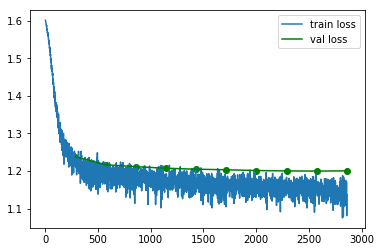

In [49]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
train_loss = np.array(ncf.get_train_summary("Loss"))
val_loss = np.array(ncf.get_validation_summary("Loss"))
#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.plot(train_loss[:,0],train_loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='val loss',color='green')
plt.scatter(val_loss[:,0],val_loss[:,1],color='green')
plt.legend();